In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'


annotations = pd.read_csv('../data_tables/ergosterol_annotations.tsv',sep = '\t', index_col='var_id')
gxe = pd.read_csv('../data_tables/ergosterol_pathway_gxe_interactions.tsv', sep = '\t')
var_fits = pd.read_csv('../data_tables/Fitness_files/ergosterol_pathway_fitness.tsv', sep = '\t')
annotated_gxe = gxe.merge(annotations,'inner','var_id')
annotated_fits = var_fits.merge(annotations,'inner','var_id')

In [2]:
def get_GxE_vars(annotated_gxe_df, annotated_fitness_df):
    '''This code generates the list of GxE variants based on our stringent two-part definition:
    1) the variant has a GxE term with FDR<0.01, and 2) for that term, the direction
    of effect in the two conditions is in opposite directions.
    inputs:
        annotated_gxe_df (pandas DataFrame): table containing pairwise GxE coefficients and pvalues for variants,
        annotated by genomic location.
        annotated_fitness_df (pandas DataFrame):  table containing fitness values for variants in 
        all relevant conditions,annotated by genomic location.
    returns:
        gxe_vars (list of strings): list of variants which show GxE according to our definition 
        (not unique, many represented multiple times) 
    '''
    gxe_vars =[] 
    for i, row in annotated_gxe_df[(annotated_gxe_df['padj']<0.01)].iterrows():
        var = row['var_id']
        conds = row['gxe'].split('-')
        if annotated_fitness_df[(annotated_fitness_df['var_id']==var)&\
                                (annotated_fitness_df['condition'].isin(conds))]['coef'].prod()<0:
            gxe_vars.append(var)
    return gxe_vars

In [3]:
annotated_fits['num_conds'] = annotated_fits.groupby('var_id')['coef'].transform('size')

#getting all variants measured in all 6 conditions with at least one significant
#effect on fitness
hit_in_one_cond = annotated_fits[(annotated_fits['num_conds']==6)&(annotated_fits['padj']<.01)]['var_id'].unique()

#getting variants with significant GxE interactions
gxe_vars = get_GxE_vars(annotated_gxe,annotated_fits)

#getting variants with significant fitness effects which do not show GxE
not_gxe =set(hit_in_one_cond)-set(gxe_vars)

#calculating the fraction of variants showing Gxe
print('Fraction GxE: '+str(round(1-len(not_gxe)/len(hit_in_one_cond),4))) 
real_frac_gxe = 1-len(not_gxe)/len(hit_in_one_cond)

Fraction GxE: 0.9366


In [4]:
len(hit_in_one_cond)

205

In [5]:
#getting all variants measured in all 6 conditions with at least one significant
#effect on fitness

hitset = annotated_fits[annotated_fits['var_id'].isin(hit_in_one_cond)]

#recoding these variants as to whether or not they have a significant GxE interaction,
#1 if they show GxE, 0 if not
hitset.loc[hitset['var_id'].isin(set(gxe_vars)), 'GxE'] = 1
hitset.loc[~hitset['var_id'].isin(set(gxe_vars)), 'GxE'] = 0

#recoding the fitness effects of these variants into 4 bins for easier visualization
#in the heatmap
#for significant fitness effects, they are coded as 1 or -1 depending on their direction
hitset.loc[(hitset['coef']>0)&(hitset['padj']<.01),'codedfitness'] = 1
hitset.loc[(hitset['coef']<0)&(hitset['padj']<.01),'codedfitness'] = -1

#for non-significant effects, they are coded as 0.45 and -0.45 depending on direction.
hitset.loc[(hitset['padj']>=.01)&(hitset['coef']>0),'codedfitness'] = .45
hitset.loc[(hitset['padj']>=.01)&(hitset['coef']<0),'codedfitness'] = -.45

In [6]:
gxe_heatmap_df = hitset[['var_id','GxE']].drop_duplicates()
gxe_heatmap_df.index = gxe_heatmap_df['var_id']

In [8]:
gxe_heatmap_df.drop('var_id',axis= 1 ,inplace = True)
fitness_heatmap_df = hitset.pivot('var_id','condition','codedfitness').dropna()

#sorting the fitness columns and GxE column together so they will be in the same order
merged_df = fitness_heatmap_df.merge(gxe_heatmap_df,'inner',right_index=True,left_index = True)
ordering = merged_df.sort_values(['GxE','LOV','CAFF','COCL','TBF','SC','NACL']).index

In [9]:
plt.subplots(figsize=(.3,1.75))


a = sns.heatmap(gxe_heatmap_df.loc[ordering],cmap = ['lightgrey','green'],cbar = None)
a.set(yticklabels=[],yticks = [], ylabel=None)
plt.xlabel(None)
plt.savefig('../GxE_Figures/Figure_4/fig4f_ii_ergosterol_heatmap_GxE.svg')

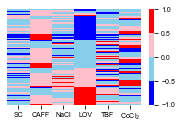

In [10]:
plt.subplots(figsize=(3,1.75))

cg = sns.heatmap(fitness_heatmap_df.loc[ordering, ['SC','CAFF','NACL','LOV','TBF','COCL']],\
                 cmap = ['red','pink','skyblue','blue'][::-1],yticklabels=False, cbar = True)


plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5],['SC','CAFF','NaCl','LOV','TBF','CoCl$_2$'])

plt.xlabel(None)
plt.ylabel(None)
plt.savefig('../GxE_Figures/Figure_4/fig4f_ergosterol_heatmap_FCs.svg')